In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

# Ein paar Definitionen vorab
import locale
locale.setlocale(locale.LC_ALL, 'de_DE.UTF-8')
c_apfelgruen = '#A1D884'
c_technikblau = '#003B5C'
c_orange = '#BE531C'
c_mint = '#8FD6BD'
c_petrol = '#115E67'
c_senfgelb = '#D9C756'
c_kirschrot = '#A50034'
c_graublau = '#B6CFD0'

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18
LARGE_SIZE = 20

plt.rc('font', size=LARGE_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=LARGE_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=LARGE_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=LARGE_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=LARGE_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LARGE_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)  # fontsize of the figure title

# Einführung

Die Kenntnis der Sonneneinstrahlung am Standort einer Photovoltaikanlage ist von entscheidender Bedeutung, um daraus den Stromertrag berechnen bzw. abschätzen zu können und um die Performance Ratio (PR) als Qualitätskennzahl einer PV-Anlage zu berechnen. 

In der Regel liegen Einstrahlungsdaten am Standort der PV-Anlage nicht vor, da kein geeignetes Messsystem vorhanden ist. Wettermessstationen befinden sich nicht in unmittelbarer Nähe zur Anlage, sodass die Einstrahlungsmessdaten ggf. sehr ungenau sind, wenn diese auf den Standort der PV-Anlage umgerechnet werden. Flächendeckend liegen nur Messdaten der Sonneneinstrahlung auf Satellitenbasis vor, welche die Dichte der Wolkendecke bestimmen und daraus die Einstrahlungsdaten am Boden berechnen. 

Die Einstrahlungsmessdaten liegen meistens für die Horizontale vor, d.h. wie groß die Strahlungsleistung bzw. eingestrahlte Energie pro Quadratmeter auf die horizontale Ebene ist. Da die PV-Module eine Neigung aufweisen (abhängig vom Standort und den äußeren Umständen wie z.B. die Orientierung und Neigung eines Satteldachs), muss die horizontale Einstrahlung in die geneigte Ebene umgerechnet werden. Hierzu müssen der direkte und diffuse Anteil der Horizontalstrahlung bekannt sein, um daraus die drei Einstrahlungsanteile direkt, diffus und reflektiert in die geneigte Modulebene zu ermitteln.

Im Folgenden wird zunächst erläutert, wie der Zugriff auf horizontale Strahlungsdaten für Standorte in Europa über den <a href="http://www.soda-pro.com/de/web-services/radiation/cams-radiation-service/info">CAMS Radiation Service</a> des <a href="http://www.copernicus.eu/">COPERNICUS</a> Erdbeobachtungsprogramms der EU erfolgt. Anschließend wird ein Skript zur Berechnung der Einstrahlung in die geneigte Ebene auf Basis des isotropen Himmelsmodells für diffuse Strahlung vorgestellt. Schließlich wird dargestellt, wie die Python-Bibliothek <a href="https://pvlib-python.readthedocs.io/">pvlib</a> der <a href="https://pvpmc.sandia.gov/">PVPerformance Modeling Collaborative</a> der Sandia National Laboratories genutzt werden kann, um die Einstrahlungsumrechnung durchzuführen.

# Inhaltsverzeichnis

<a href="#cams_radiation_service">1 CAMS Radiation Service</a><br />
<a href="#einlesen_CAMS-CSV-Datei">2 Einlesen der CAMS-CSV-Datei und Übertragen der Daten in einen DataFrame</a><br />
<a href="#funktion_berechnung_einstrahlung">3 Funktion zur Berechnung der Einstrahlung in die geneigte Ebene</a><br />
<a href="#pvlib">4 Einstrahlungsberechnung mithilfe der PVLIB der PVPerformance Modeling Collaborative</a><br />
<a href="#zusammenfassung">5 Zusammenfassung</a>

<a id="cams_radiation_service"></a>
## 1 CAMS Radiation Service

Über die Webseite des COPERNICUS Erdbeoachtungsprogramms der Europäischen Union können <a href="http://www.soda-pro.com/de/web-services/radiation/cams-radiation-service/info">Strahlungsdaten</a> (entsprechend der <a href="http://www.soda-pro.com/documents/10157/326300/CAMS-data-license.pdf/59241f5b-085d-4e79-bf42-1f19b0731d9f">Nutzungslizenz</a>) bezogen und weiterverarbeitet werden. Hierzu ist lediglich eine Registrierung notwendig. Die URL des CAMS Radiation Service lautet:

<a href="http://www.soda-pro.com/de/web-services/radiation/cams-radiation-service/info">http://www.soda-pro.com/de/web-services/radiation/cams-radiation-service/info</a>

Für Matlab und Python gibt es vordefinierte Skripte für das Abrufen der Einstrahlungsdaten im CSV-Format. Auch ein automatischer Zugriff über <code><a href="http://www.soda-pro.com/de/help/cams-services/cams-radiation-service/automatic-access#wget">wget</a></code> anstatt über die Webseite ist möglich; hierfür ist die E-Mailadresse aus der Registrierung notwendig, da der Zugriff derzeit auf 40 Datenabrufe pro Tag beschränkt ist.

An dieser Stelle wird nicht der Webservice zur Abfrage der Einstrahlungsdaten erläutert, sondern der <code>wget</code>-Zugriff zum direkten Herunterladen der CSV-Datei. Auf der CAMS-Webseite ist der Zugriff auf ein <code><a href="http://www.soda-pro.com/de/help/cams-services/cams-radiation-service/automatic-access#wget">wget</a></code>-Skript möglich. Unter folgender Adresse kann das modifizierte Skript <code>wget_cams_radiation.sh</code> heruntergeladen werden; die Modifikationen erlauben eine einfache Anpassung der Parameter:<br />
<a href="https://www.umwelt-campus.de/ucb/fileadmin/users/176_h.teheesen/script/irradiance/wget_cams_radiation.sh">https://www.umwelt-campus.de/ucb/fileadmin/users/176_h.teheesen/script/irradiance/wget_cams_radiation.sh</a>

<strong>Hinweis:</strong> Damit das Bash-Skript durchläuft, muss die E-Mailadresse unter <code>username</code> angepasst werden. Mit der vordefinierten Mailadresse wird die CAMS-CSV-Datei nicht heruntergeladen.

In [2]:
%%bash
#!/bin/sh
#
# CAMS Radiation request using wget (Unix).
#
# Modified by Henrik te Heesen
#
# Version 0.1
#
# Please change the location and other parameters according to your needs.
# See http://www.soda-pro.com/help/cams-services/cams-radiation-service/automatic-access

usage="

Script to request and download the CAMS radiation by wget

Website: http://www.soda-pro.com/de/web-services/radiation/cams-radiation-service

REMARK: You have to register on the CAMS website to get autmatic access to the irradiance data.

$(basename "$0") [-h] [-v] [-f -x -o -a -b -e -h -s -u]

where:
	-h  Show this help
	-v  Version
	-f  Output file name
	-x  If the decimal separator "." shall be replaced by a "," (for usage of CSV file in German Excel), set the value to 1
	-o  Longitude of the location in degree (0° is Greenwich, positive values to the east)
	-a  Latitude of the location in degree (-90° south pole, 0° is equator and +90° north pole)
	-b  Begin of time period. Format: YYYY-mm-dd
	-e  End of time period. Format: YYYY-mm-dd
	-h  Altitude in meters. Omit this parameter or set altitude to -999 to let SoDa get the altitude from NASA SRTM database
	-s  Time interval: PT01M (1 minute), PT15M (15 minutes), PT01H (hourly), P01D (daily), P01M (monthly)
	-u  Mail address which has been used for registration on CAMS website. The reason for registration is that CAMS need to identify you when launching the requests for statistical constraints imposed by the European Union.
         	Mac/Linux: replace the "@" by a single %2540
         	Windows: replace the "@" by a double %%2540
         	Unix-Example: mymailaddress%2540example.com

"

################
# Default values
# output file
output_file=cams_radiation.csv

# If the decimal separator "." shall be replaced by a "," (for usage of CSV file in German Excel), set the value to 1
output_excel=0

# longitude of location
longitude=7.169

# latitude of location
latitude=49.608

# Begin of time period. Format: YYYY-mm-dd
date_begin=2017-01-01

# End of time period. Format: YYYY-mm-dd
date_end=2017-12-31

# Altitude in meters. Set "altitude =-999" to let SoDa get the altitude from NASA SRTM database
altitude=-999

# Time interval
# PT01M (1 minute), PT15M (15 minutes), PT01H (hourly, default), P01D (daily), P01M (monthly)
summarization=PT01H

# Mail address which has been used for registration on CAMS website. The reason for registration is that CAMS need to identify you when launching the requests for statistical constraints imposed by the European Union.
# Mac/Linux: replace the "@" by a single %2540
# Windows: replace the "@" by a double %%2540
# Example: mymailaddress%2540example.com
username=h.teheesen%2540umwelt-campus.de

while getopts hvf:x:o:a:b:e:h:s:u: option; do
	case "${option}" in
		h) echo "$usage"
			exit 0
			;;
		v) echo "
Version 0.1 by Henrik te Heesen

Use '$(basename "$0") -h' for more information.
"
			exit 0
			;;
		f) output_file=${OPTARG};;
		x) output_excel=${OPTARG};;
		o) longitude=${OPTARG};;
		a) latitude=${OPTARG};;
		b) date_begin=${OPTARG};;
		e) date_end=${OPTARG};;
		h) altitude=${OPTARG};;
		s) summarization=${OPTARG};;
		u) username=${OPTARG}
echo "
$username"
;;
	esac
done

# Try main SoDa server www.soda-is.com
wget -O $output_file "http://www.soda-is.com/service/wps?Service=WPS&Request=Execute&Identifier=get_cams_radiation&version=1.0.0&DataInputs=latitude=$latitude;longitude=$longitude;altitude=$altitude;date_begin=$date_begin;date_end=$date_end;time_ref=UT;summarization=$summarization;username=$username&RawDataOutput=irradiation"

# On error, try SoDa server mirror pro.soda-is.com
if [ $? -ne 0 ]; then
    wget -O $output_file "http://pro.soda-is.com/service/wps?Service=WPS&Request=Execute&Identifier=get_cams_radiation&version=1.0.0&DataInputs=latitude=$latitude;longitude=$longitude;altitude=$altitude;date_begin=$date_begin;date_end=$date_end;time_ref=UT;summarization=$summarization;username=$username&RawDataOutput=irradiation"
fi

if [ "$output_excel" -eq 1 ]; then
    sed -i -e 's/\./,/g' $output_file
fi

--2018-08-10 09:29:10--  http://www.soda-is.com/service/wps?Service=WPS&Request=Execute&Identifier=get_cams_radiation&version=1.0.0&DataInputs=latitude=49.608;longitude=7.169;altitude=-999;date_begin=2017-01-01;date_end=2017-12-31;time_ref=UT;summarization=PT01H;username=h.teheesen%40umwelt-campus.de&RawDataOutput=irradiation
Aufl"osen des Hostnamens www.soda-is.com (www.soda-is.com)... 77.158.181.126
Verbindungsaufbau zu www.soda-is.com (www.soda-is.com)|77.158.181.126|:80 ... verbunden.
HTTP-Anforderung gesendet, auf Antwort wird gewartet ... 500 Internal Server Error
2018-08-10 09:29:11 FEHLER 500: Internal Server Error.

--2018-08-10 09:29:11--  http://www.soda-is.com/service/wps?Service=WPS&Request=Execute&Identifier=get_cams_radiation&version=1.0.0&DataInputs=latitude=49.608;longitude=7.169;altitude=-999;date_begin=2017-01-01;date_end=2017-12-31;time_ref=UT;summarization=PT01H;username=h.teheesen%2540umwelt-campus.de&RawDataOutput=irradiation
Verbindungsaufbau zu www.soda-is.com 

Das Skript wird in der Unix/Mac-Kommandozeile folgendermaßen ausgeführt:

<code>wget_cams-radiation.sh -h</code> 

ruft die Hilfe auf und

<code>wget_cams_radiation.sh -f cams_radiation.csv -x 0 -o 7.169 -a 49.608 -b 2017-01-01 -e 2017-12-31 -h -999 -s PT01H -u mymailaddress%2540example.com</code>

führt das Skript aus, um für den Standort des Umwelt-Campus Birkenfeld in Neubrücke (Nahe) (Längengrad 7,169°, Breitengrad 49.608°) die Einstrahlungsdaten für den Zeitraum 01.01.2017 bis 31.12.2017 in stündlicher Auflösung über CAMS herunterzuladen und in der Datei <code>cams_radiation.csv</code> zu speichern. Bei der E-Mailadresse, die zur Registrierung verwendet wurde, muss das <code>@</code>-Zeichen durch <code>%2540</code> unter Unix/Mac bzw. <code>%%2540</code> unter Windows ersetzt werden. Die Anwendung von wget unter Windows wird ebenfalls auf der <a href="http://www.soda-pro.com/de/help/cams-services/cams-radiation-service/automatic-access#wget">CAMS-Webseite</a> erläutert.

In dem Shell-Skript können die Standart-Parameter durch andere Werte ersetzt werden, um diese nicht bei jedem Aufruf erneut an das Skript übergeben zu müssen. 

Eine exemplarische CSV-Datei kann hier heruntergeladen werden:<br />
<a href="https://www.umwelt-campus.de/ucb/fileadmin/users/176_h.teheesen/script/irradiance/cams_radiation.csv">https://www.umwelt-campus.de/ucb/fileadmin/users/176_h.teheesen/script/irradiance/cams_radiation.csv</a>

In der CSV-Datei werden in den ersten Zeilen zunächst die Eingangsparameter sowie die Inhalte und Bedeutungen der einzelnen Datenspalten erläutert. Ab etwa Zeile 42 folgen die abgerufenen Daten für den betrachteten Zeitraum mit dem entsprechenden Zeitintervall.

Exemplarisch sind in folgender Tabelle die Einstrahlungsdaten für den 21.06.2017 im Zeitraum 12:00-13:00 Uhr dargestellt (die Zeilen und Spalten sind zur besseren Darstellung gedreht). Die fett markierten Zeilen geben die Daten an (globale (GHI), direkte (BHI) und diffuse (DHI) Einstrahlung in die Horizontale), die im weiteren Verlauf der Berechnung der Einstrahlung in die geneigte Ebene weiterverarbeitet werden. Die Einheit der Messdaten ist $\text{Wh}/\text{m}^2$.

<table style="width:100%">
    <tr>
        <th>Bezeichnung</th><th>Erläuterung</th><th>Wert</th>
    </tr>
    <tr>
        <td><strong>Observation period</strong></td><td><strong>Observation period (ISO 8601)</strong></td><td><strong>2017-06-21T12:00:00,0/2017-06-21T13:00:00,0</strong></td>
    </tr>
    <tr>
        <td>TOA</td><td>Irradiation on horizontal plane at the top of atmosphere (Wh/m2)</td><td>1156.9075</td>
    </tr>
    <tr>
        <td>Clear sky GHI</td><td>Clear sky global irradiation on horizontal plane at ground level (Wh/m2)</td><td>861.6588</td>
    </tr>
    <tr>
        <td>Clear sky BHI</td><td>Clear sky beam irradiation on horizontal plane at ground level (Wh/m2)</td><td>670.0613</td>
    </tr>
    <tr>
        <td>Clear sky DHI</td><td>Clear sky diffuse irradiation on horizontal plane at ground level (Wh/m2)</td><td>191.5974</td>
    </tr>
    <tr>
        <td>Clear sky BNI</td><td>Clear sky beam irradiation on mobile plane following the sun at normal incidence (Wh/m2)</td><td>763.3409</td>
    </tr>
    <tr>
        <td><strong>GHI</strong></td><td><strong>Global irradiation on horizontal plane at ground level (Wh/m2)</strong></td><td><strong>697.7711</strong></td>
    </tr>
    <tr>
        <td><strong>BHI</strong></td><td><strong>Beam irradiation on horizontal plane at ground level (Wh/m2)</strong></td><td><strong>322.8442</strong></td>
    </tr>
    <tr>
        <td><strong>DHI</strong></td><td><strong>Diffuse irradiation on horizontal plane at ground level (Wh/m2)</strong></td><td><strong>374.9269</strong></td>
    </tr>
    <tr>
        <td>BNI</td><td>Beam irradiation on mobile plane following the sun at normal incidence (Wh/m2)</td><td>367.2331</td>
    </tr>
    <tr>
        <td>Reliability</td><td>Proportion of reliable data in the summarization (0-1)</td><td>1</td>
    </tr>
</table>

<a id="einlesen_CAMS-CSV-Datei"></a>
## 2 Einlesen der CAMS-CSV-Datei und Übertragen der Daten in einen DataFrame

Nachdem die CSV-Datei vom CAMS-Server heruntergeladen wurde, werden die Daten aus den vier Spalten Observation period, GHI, BHI und DHI in einen DataFrame übertragen.

Das Skript <code>camsReader.py</code> kann unter folgendem Link heruntergeladen werden:<br />
<a href="https://www.umwelt-campus.de/ucb/fileadmin/users/176_h.teheesen/script/irradiance/camsReader.py">https://www.umwelt-campus.de/ucb/fileadmin/users/176_h.teheesen/script/irradiance/camsReader.py</a>

In [3]:
import pandas as pd
from datetime import datetime

def openAndSkipLines(f, symbol):
    
    """
    open a file, e.g. a CSV file, and skip lines beginning with symbol. Return the total number of lines and number of lines to skip (i.e. not containing data). If < 0, file is empty
    The file is ready to be read at the first line of data
    
    Parameters
    ----------
    f : str
        filename of the CAMS CSV file
    symbol : str
        symbol for comment rows
    
    Returns
    -------
    nbTotalLines : numeric
        Total number of lines of the file
    nbLinesToSkip : numeric
        Line number which have to be skipped to reach the data block
    
    """

    nbTotalLines = len(f.readlines())
    if (nbTotalLines == 0): 
        return -1, -1
    f.seek(0,0)
    stop = False
    nbLine = 0
    while (not stop):
        nbLine = nbLine + 1
        l = f.readline()
        if (l[0] != symbol): stop = True
    f.seek(f.tell()-len(l),0)
    nbLinesToSkip = nbLine-1
    return nbTotalLines, nbLinesToSkip 

def getCamsData(camsFile):
    
    """
    List of variables in CAMS files
    Observation period;TOA;Clear sky GHI;Clear sky BHI;Clear sky DHI;Clear sky BNI;GHI;BHI;DHI;BNI;Reliability
    
    Parameters
    ----------
        camsFile : str
            Filenname of CAMS CSV file
    
    Returns
    -------
        df : DataFrame
            DataFrame with the columns dateBegins (index column), dateEnds, ghi, bhi, dhi
    """


    array = []
    for ll in camsFile.readlines():
        ll = ll[0:len(ll)-1]
        l = ll.split(';')
        date = l[0].split('/')

        array.append([datetime.strftime(datetime.strptime(date[0].strip()[:-5], "%Y-%m-%dT%H:%M"), "%Y-%m-%d %H:%M:00"), datetime.strftime(datetime.strptime(date[1].strip()[:-5], "%Y-%m-%dT%H:%M"), "%Y-%m-%d %H:%M:00"), float(l[6].strip()), float(l[7].strip()), float(l[8].strip())])
            
    df = pd.DataFrame(array, columns=['dateBegins', 'dateEnds', 'ghi', 'bhi', 'dhi'])
    df['dateBegins'] = df['dateBegins'].apply(pd.to_datetime)
    df['dateEnds'] = df['dateEnds'].apply(pd.to_datetime)
    df.set_index(pd.DatetimeIndex(df['dateBegins']), inplace=True)
    del df['dateBegins']
        
    return df


#File Name
fileName = 'cams_radiation.csv'


f = open(fileName)
nbTotalLines = 0
nbLinesToSkip = 0

nbTotalLines, nbLinesToSkip = openAndSkipLines(f, '#')
if (nbTotalLines < 0):
  print('File', fileName, ' is empty')
  exit()

sizeData = nbTotalLines - nbLinesToSkip

df_cams = getCamsData(f) # get data as DataFrame
f.close()


Das Skript liest die Daten aus der CAMS-CSV-Datei ein, identifiziert den Anfang des Datenblocks und übergibt die Werte zur Globalstrahlung (ghi), direkten Einstrahlung (bhi) sowie diffusen Einstrahlung (dhi) in die Horizontale an einen DataFrame. Zudem werden der Anfangszeitpunkt (dateBegins) und Endzeitpunkt (dateEnds) des Zeitintervalls in dem DataFrame gespeichert.

In dem Skript muss lediglich der Dateiname der CSV-Datei mit den CAMS-Einstrahlungsdaten angegeben werden. Anschließend können die Daten aus dem DataFrame weiterverarbeitet werden. In folgendem Beispiel sind die Werte der horizontalen Einstrahlung global, direkt, diffus, die Jahressummen der drei Einstrahlungsarten sowie die Monatssummen der globalen horizontalen Einstrahlung als Balkengrafik aufgeführt.

dateEnds    2017-06-21 13:00:00
ghi                     697.771
bhi                     322.844
dhi                     374.927
Name: 2017-06-21 12:00:00, dtype: object

Globale horizontale Einstrahlung GHI in 2017: 1212.5 kWh/m^2
Direkte horizontale Einstrahlung BHI in 2017:  631.3 kWh/m^2
Diffuse horizontale Einstrahlung GHI in 2017:  582.8 kWh/m^2


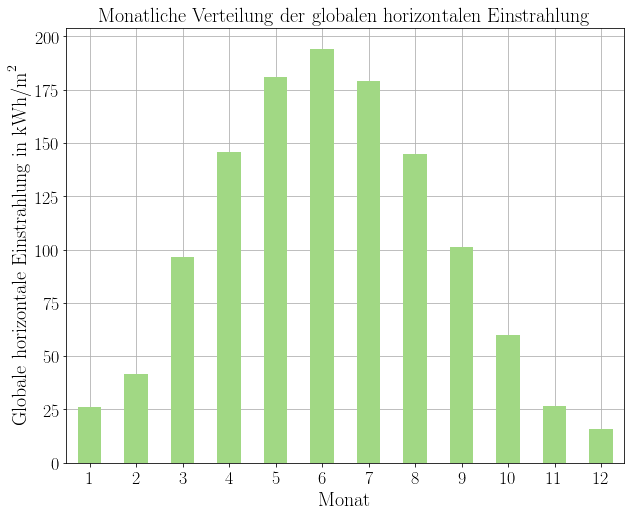

In [4]:
# Horizontale Einstrahlung am 21.06.2017 um 12 Uhr 
print(df_cams.loc['2017-06-21 12:00:00'])
print()

# Summe der Einstrahlung in kWh/m^2
print ("Globale horizontale Einstrahlung GHI in 2017: {0:6.1f} kWh/m^2". format(sum(df_cams.ghi)/1000))
print ("Direkte horizontale Einstrahlung BHI in 2017: {0:6.1f} kWh/m^2". format(sum(df_cams.bhi)/1000))
print ("Diffuse horizontale Einstrahlung GHI in 2017: {0:6.1f} kWh/m^2". format(sum(df_cams.dhi)/1000))

# Monatliche Verteilung der globalen horizontalen Einstrahlung
import matplotlib.pyplot as plt
import calendar

df_plot = pd.DataFrame(df_cams.resample('M').sum().ghi)
df_plot.index = df_plot.index.month
df_plot.ghi = df_plot.ghi/1000

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
ax = df_plot.plot(kind='bar', title="Monatliche Verteilung der globalen horizontalen Einstrahlung", color=c_apfelgruen, legend=False, figsize=(10, 8), fontsize=18, zorder=2)
plt.xticks(rotation=0)
ax.set_xlabel("Monat")
ax.set_ylabel(r"Globale horizontale Einstrahlung in $\textnormal{kWh/m}^2$")
ax.grid(zorder=1)
plt.show()

<a id="funktion_berechnung_einstrahlung"></a>
## 3 Funktion zur Berechnung der Einstrahlung in die geneigte Ebene

Aus den Daten zur horizontalen Sonneneinstrahlung soll im nächsten Schritt die Einstrahlung in die geneigte Ebene berechnet werden. Hierzu müssen der Standort, das Datum und die Uhrzeit sowie die Ausrichtung und Neigung der Ebene bekannt sein, da die Umrechnung der Einstrahlung von diesen Parametern abhängig ist. Eine Beschreibung zu den Methoden der Umrechnungen ist auf der Webseite der Sandia National Laboratories zur <a href="https://pvpmc.sandia.gov/"> PVPerformance Modeling Collaborative</a> unter <a href="https://pvpmc.sandia.gov/modeling-steps/">Modeling Steps</a> oder beim <a href="https://rredc.nrel.gov/solar/pubs/spectral/model/spectral_model_index.html">Renewable Resource Data Center der NREL </a>zu finden.

Zunächst werden die Eingangsparameter für die Berechnung der Einstrahlung in die geneigte Ebene definiert. Hierzu zählen der Zeitpunkt der Berechnung, 21. Juni 2017, 12 Uhr (mit einer Zeitzone von +2 wegen der Sommerzeit), der Längen- und Breitengrad, wie bereits oben verwendet für den Standort des Umwelt-Campus Birkenfeld in Neubrücke (Nahe), die Ausrichtung (180° und damit nach Süden) die Neigung der PV-Module (30° geneigt), die Reflektionsfähigkeit des Bodens (die Albedo) mit 0,2 sowie die direkte und diffuse horizontale Einstrahlung, bestimmt aus der CAMS-Datei zum gewählten Zeitpunkt.

Die Basemap im darauffolgenden Skriptteil veranschaulicht den gewählten Standort der Anlage auf der Weltkarte.

In [5]:
# Input parameter

# Date and time of the calculation
# actual_date = [timestamp as a string, timezone]
# timestamp as a string in datetime format "YYYY-mm-dd HH:MM:SS"
# timezone: For Germany: timezone = 1 is CET (winter time), timezone = 2 (CEST) is daylight saving time
timestamp = ["2017-06-21 12:00:00", 2]

# location of PV system
# location = [longitude, latitude]
# Longitude in °. Positive values are to the east, negative values are to the west, 0° is Greenwich meridian
# Latitude in °. South pole is -90°, equator is 0°, north pole is +90°
longitude = 7.169
latitude = 49.608
location = [longitude, latitude] # Location of Umwelt-Campus Birkenfeld 

# Orientation of the PV system 
# orientation = [azimuth angle (horizontal orientation), inclinaction angle]
# Azimuth angle in °. 0° is north, 90° is east, 180° is south, 270° is west
# Inclination angle in °. 0° is horizontal, 90° is vertical
azimuth = 180
inclination = 30
orientation = [azimuth, inclination]

# Albedo (refleciton of the ground). Default value is  0.2
A = 0.2

# Horizontal irradiance within the time period in Wh per square meter
# E_hor = [direct horizontal irradiance in Wh/m^2, diffuse horizontal irradiance in Wh/m^2]
bhi = df_cams.loc[timestamp[0]].bhi
dhi = df_cams.loc[timestamp[0]].dhi
ghi = df_cams.loc[timestamp[0]].ghi
E_hor = [bhi, dhi]

/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


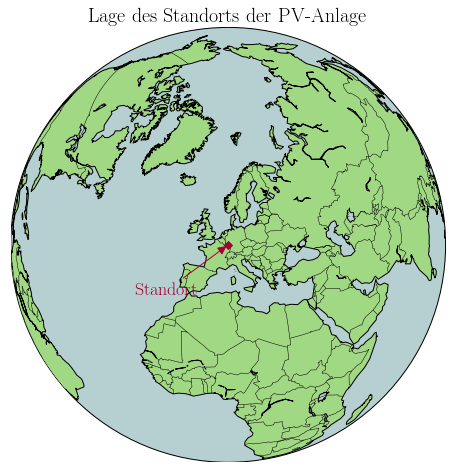

In [6]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))

map = Basemap(projection='ortho', lat_0=latitude, lon_0=longitude)

map.drawmapboundary(fill_color=c_graublau)
map.fillcontinents(color=c_apfelgruen, lake_color=c_graublau)
map.drawcoastlines()
map.drawcountries()

x, y = map(longitude, latitude)
x2, y2 = (longitude-100), (latitude-100)

plt.annotate('Standort', xy=(x, y),  xycoords='data',
                xytext=(x2, y2), textcoords='offset points',
                color=c_kirschrot, fontsize=18, arrowprops=dict(arrowstyle='-|>', color=c_kirschrot)
                )

map.plot(x, y, marker='D',color=c_kirschrot)
plt.title("Lage des Standorts der PV-Anlage")

plt.show()

Die Funktion <code>calc_tilted_irradiance(timestamp, location, orientation, A, E_hor)</code> berechnet die direkte, diffuse und reflektierte Einstrahlung in die geneigte Ebene aus den oben gegebenen Parametern. Übergeben werden der Zeitstempel, der Standort, die Orientierung der PV-Module, die Albedo sowie die horizontale Einstrahlung. Die Funktion berechnet die wahre Ortszeit zum gegebenen Zeitpunkt am Standort der PV-Anlage, den Sonnenhöhenwinkel sowie den Sonnenazimuthwinkel und übergibt schließlich die Einstrahlung in die geneigte Ebene als Tupel von drei Werten zurück. 

Die Funktion kann in andere Python-Skripte übernommen werden, um die Umrechnung der Einstrahlung von der Horizontalen in die geneigte Ebene durchzuführen.

Das Skript <code>calc_tilted_irradiance.py</code> kann unter folgendem Link heruntergeladen werden:<br />
<a href="https://www.umwelt-campus.de/ucb/fileadmin/users/176_h.teheesen/script/irradiance/calc_tilted_irradiance.py">https://www.umwelt-campus.de/ucb/fileadmin/users/176_h.teheesen/script/irradiance/calc_tilted_irradiance.py</a>

In [7]:
import datetime
import math
import calendar
import numpy as np

def calc_tilted_irradiance(timestamp, location, orientation, A, E_hor):
        
    """ 
    Calculaction of the direct, diffuse and reflected irradiance in the tilted module plane with the isotropic sky diffuse model
    
    
    Parameters
    ----------   
    timestamp : list of [actual date as str, timezone offset as numeric]
        actual date is a string "YYYY-mm-dd HH:MM:SS"
        timezone offset is the offset from UTC (for Germany +1 in winter and +2 in summer)
    location : list with [longitude as numeric, latitude as numeric]
        longitude of the location of the PV system in degree (0° is Greenwich, positive values to the east)
        latitude of the location of the PV system in degree (-90° south pole, 0° is equator and +90° north pole)
    orientation : list with [azimuth angle as numeric, inclination angle as numeric]
        azimuth angle (horizontal orientation) of the PV system (0° north, 90° east, 180° south, 270° west)
        inclination angle of the PV system (0° is horizontally mounted, 90° is vertically mounted)
    A : Albedo as numeric
        Reflection factor of the ground: Default value is 0.2. Larger values show a higher reflection value
    E_hor : list with [direct horizontal irradiance as numeric, diffuse horizontal irradiance as numeric]
        direct horizontal irradiance per square meter
        diffuse horizontal irradiance per square meter
        
    Returns
    -------
    titled irradiance : tuple
        Direct irradiance in tilted module plane in Wh per squaremeter : numeric
        Diffuse irradiance in tilted module plane in Wh per squaremeter : numeric
        Reflected irradiance in tilted module plane in Wh per squaremeter : numeric
    """
    
    actual_date = timestamp[0]
    timezone = timestamp[1]
    
    L = math.radians(location[0])
    phi = math.radians(location[1])
    
    module_azimuth_angle = math.radians(orientation[0])
    module_elevation_angle = math.radians(orientation[1])
    
    E_dir_hor = E_hor[0]
    E_diff_hor = E_hor[1]
    E_G_hor = E_dir_hor + E_diff_hor

    # Plausibility checks
    error = 0
    if ( (timezone<-12) or (timezone>12) ):
        print ("Timezone has wrong value. Timezone must be betwenn -12 and +12.")
        error+=1
        
    if ( (location[0]<-180) or (location[0]>180) ):
        print ("Longitude has wrong value. Longitude must be between -180° and +180°.")
        error+=1
    
    if ( (location[1]<-90) or (location[1]>90) ):
        print ("Latitude has wrong value. Latitude must be between -90° and +90°.")
        error+=1
    
    if ( (orientation[0]<0) or (orientation[0]>360) ):
        print ("Module orientation has wrong value. Orientation must be between 0° and 360°. Southern orientation is 180°")
        error+=1
        
    if ( (orientation[1]<0) or (orientation[1]>90) ):
        print ("Modul inclination has wrong value. Inclination must be between 0° and +90°. 0° is horizontal.")
        error+=1
    
    if ( (A<0) or (A>1) ):
        print ("Albedo has wrong value. Albedo must be between 0 and 1. Default value is A=0.2")
        error+=1
    
    if ( E_hor[0]<0 ):
        print ("Direct horizontal irradiance has negative value. Direct horizontal irradiance must be positive.")
        error+=1
    
    if ( E_hor[1]<0 ):
        print ("Diffuse horizontal irradiance has negative value. Diffuse horizontal irradiance must be positive.")
        error+=1
        
    if (error > 0):
        raise SystemExit("Script aborted.")
        
    
    actual_date_formated = datetime.datetime.strptime(actual_date,"%Y-%m-%d %H:%M:%S")
    first_day = datetime.datetime(actual_date_formated.year, 1, 1, 0, 0, 0)
    
    number_of_days = 365
    if (calendar.isleap(actual_date_formated.year)):
        number_of_days = 366
        
    n = ((actual_date_formated-first_day).days)+1
    j = 360*n/number_of_days

    declination_angle = math.radians( 0.3948 - 23.2559*math.cos( math.radians(j+9.1) ) - 0.3915*math.cos( math.radians(2*j+5.4) ) - 0.1764*math.cos( math.radians(3*j+26) ) )

    teq = ( 0.0066 + 7.3525*math.cos( math.radians(j+85.9) ) + 9.9359*math.cos( math.radians(2*j+108.9) ) + 0.3387*math.cos( math.radians(3*j+105.2) ) )


    local_time = datetime.datetime.strptime(actual_date,"%Y-%m-%d %H:%M:%S")

    mean_local_time = local_time - datetime.timedelta(hours=timezone) + 4*datetime.timedelta(minutes=math.degrees(L))

    true_local_time = mean_local_time + datetime.timedelta(minutes=teq)

    hour_angle = math.radians(15*(12-(true_local_time.hour+true_local_time.minute/60+true_local_time.second/3600)))

    sun_elevation_angle = math.asin( math.cos(hour_angle)*math.cos(phi)*math.cos(declination_angle) + math.sin(phi)*math.sin(declination_angle) )
    
    if (true_local_time.hour <= 12):
        sun_azimuth_angle = math.pi - math.acos( (math.sin(sun_elevation_angle)*math.sin(phi)-math.sin(declination_angle))/(math.cos(sun_elevation_angle)*math.cos(phi)) )
    else:
        sun_azimuth_angle = math.pi + math.acos( (math.sin(sun_elevation_angle)*math.sin(phi)-math.sin(declination_angle))/(math.cos(sun_elevation_angle)*math.cos(phi)) )
    
    solar_angle_of_incidence = math.acos( -math.cos(sun_elevation_angle)*math.sin(module_elevation_angle)*math.cos(sun_azimuth_angle-(module_azimuth_angle-math.pi))+math.sin(sun_elevation_angle)*math.cos(module_elevation_angle) )
       
    E_dir_tilted = np.maximum(E_dir_hor * math.cos(solar_angle_of_incidence),0)
        
    E_diff_tilted = E_diff_hor * 1/2 * (1 + math.cos(module_elevation_angle)) 

    E_refl_tilted = E_G_hor * A * 1/2 * (1 - math.cos(module_elevation_angle))
        
    return E_dir_tilted, E_diff_tilted, E_refl_tilted

Der Aufruf der Funktion mit der Übergabe der vier Parameter gibt einen Tupel mit den drei Werten zur direkten Einstrahlung, diffusen Einstrahlung und reflektierten Einstrahlung in die geneigte Ebene zurück.

<code>E_dir_tilted, E_diff_tilted, E_refl_tilted = calc_tilted_irradiance(timestamp, location, orientation, A, E_hor)</code>

Die Berechnung der diffusen Einstrahlung basiert auf dem <emph>Isotropic Sky Diffuse Model</emph>. Dieses Modell ist stark vereinfacht, komplexere Modelle mit genaueren Ergebnissen bei der Berechnung der diffusen Einstrahlung gibt es u.a. nach <a href="https://www.sciencedirect.com/science/article/pii/0038092X79901105">Klucher</a> oder <a href="https://www.sciencedirect.com/science/article/pii/0038092X86900137">Perez</a>.

In [8]:
# Calculatio of the irradiance in the tilted module plane
# Returned values:
# 1. Direct tilted irradiance in Wh/m^2
# 2. Diffuse tilted irradiance in Wh/m^2
# 3. Irradiance by ground reflection in Wh/m^2
E_dir_tilted, E_diff_tilted, E_refl_tilted = calc_tilted_irradiance(timestamp, location, orientation, A, E_hor)

print ("E_dir_tilted:", E_dir_tilted, "Wh/m^2")
print ("E_diff_tilted:", E_diff_tilted, "Wh/m^2")
print ("E_refl_tilted:", E_refl_tilted, "Wh/m^2")
print ("E_total_tilted:", E_dir_tilted+E_diff_tilted+E_refl_tilted, "Wh/m^2")

E_dir_tilted: 299.494453378 Wh/m^2
E_diff_tilted: 349.811559981 Wh/m^2
E_refl_tilted: 9.34836013734 Wh/m^2
E_total_tilted: 658.654373496 Wh/m^2


                  direkt     diffus  reflektiert
Einstrahlung                                    
horizontal    322.844200  374.92690      0.00000
geneigt       299.494453  349.81156      9.34836


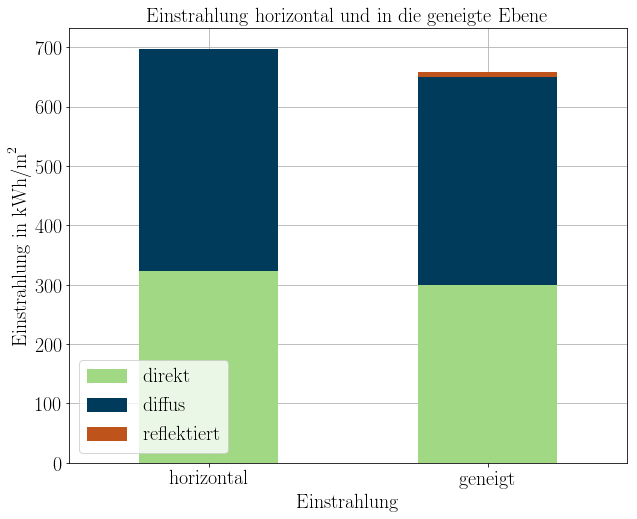

In [9]:
index_xAchse = ('horizontal', 'geneigt')
index = pd.Index(index_xAchse, name='Einstrahlung')

data = {
    'direkt': (bhi, E_dir_tilted),
    'diffus': (dhi, E_diff_tilted),
    'reflektiert': (0, E_refl_tilted)
}

df_Einstrahlung = pd.DataFrame(data, index=index)
print(df_Einstrahlung)

df_tilted = pd.DataFrame(data, index=index)
ax = df_tilted.plot(kind='bar', stacked=True, figsize=(10, 8), color=(c_apfelgruen, c_technikblau, c_orange), zorder=2)
ax.set_title("Einstrahlung horizontal und in die geneigte Ebene")
ax.set_ylabel(r"Einstrahlung in $\textnormal{kWh/m}^2$")
plt.xticks(rotation=0)
ax.legend(loc="lower left", bbox_to_anchor=(0.,0.))
ax.grid(zorder=1)
plt.show()

<a id="pvlib"></a>
## 4 Einstrahlungsberechnung mithilfe der PVLIB der PVPerformance Modeling Collaborative

Die Sandia National Laboratories haben in der <a href="https://pvpmc.sandia.gov/applications/pv_lib-toolbox/">PVPerformance Modeling Collaborative</a> eine Toolbox für Python und Matlab entwickelt, um die elektrischen Eigenschaften von PV-Anlagen zu simulieren. Hierzu zählt auch die Berechnung der Sonneneinstrahlung am Standort der PV-Anlage. Eine umfangreiche Dokumentation der Bibliothek findet sich bei <a href="https://pvlib-python.readthedocs.io/en/latest/">readthedocs</a>. Die Toolbox ist deutlich mächtiger als die oben eingeführte Funktion zur Umrechnung der Einstrahlung; jedoch ist die Funktion <code>calc_tilted_irradiance</code> ggf. etwas einfacher in der Bedienung oder eine Alternative zur Installation der PVLIB-Bibliothek.

Zunächst muss die Bibliothek installiert werden, da diese nicht zur Python-Standardinstallation gehört. Eine Installationsanleitung ist zu finden unter:<br />
<a href="https://pvlib-python.readthedocs.io/en/latest/installation.html#install-standard-release">https://pvlib-python.readthedocs.io/en/latest/installation.html#install-standard-release</a>

Um die aktuelle Version der PVLIB-Bibliothek zu installieren, wird in der Kommandozeile für die <a href="https://anaconda.org/">Anaconda Python Distribution</a> 

<code>conca install -c pvlib pvlib</code>

bzw. für jede andere Python-Distribution

<code>pip install pvlib</code>

Anschließend kann über

<code>import pvlib</code>

die PVLIB-Bibliothek in Python eingebunden werden.

Zur Berechnung der Solareinstrahlung in die geneigte Ebene mithilfe der PVLIB-Bibliothek müssen zunächst die Bibliothek eingebunden und die Eingangsparameter für die einzelnen Funktionen definiert werden. Die Parameter sind im Grunde identisch zu den Parameter für die Funktion <code>calc_tilted_irradiance</code>, jedoch sind Aufrufe der Funktionen in der PVLIB anders aufgebaut.

Neben dem Import der PVLIB wird die Klasse <code>pvlib.location</code> benötigt.

Folgende Parameter müssen angegeben werden:
- der Zeitpunkt der Berechnung als p
- der Längengrad <code>longitude</code> und Breitengrad <code>latitude</code> sowie die Zeitzone (<a href="https://en.wikipedia.org/wiki/List_of_tz_database_time_zones">Definition der Zeitzonen auf Wikipedia</a>)
- die Ausrichtung <code>surface_azimuth</code> und Neigung <code>surface_tilt</code> der PV-Module, 
- die Albedo, 
- die horizontale direkte <code>dni</code>, diffuse <code>dhi</code> und Globalstrahlung <code>ghi</code> aus der CAMS-CSV-Datei.

Anschließend muss zunächst die Sonnenposition über <code>get_solarposition</code> bestimmt werden. Für das isotrope Berechnungsmodell sowie das Modell nach Klucher für die diffuse Einstrahlung kann direkt die Funktion <code>total_irrad</code> aufgerufen werden, um die Einstrahlung in die geneigte Ebene zu berechnen. Genauer ist das Berechnungsmodell für die diffuse Einstrahlung in den Modellen nach Hay-Davies, Reindl, King und Perez - hierfür muss noch das Airmass über <code>get_airmass</code> und die direkte Normalstrahlung außerhalb der Atmosphäre über<code>dni_extra</code> über die Funktion <code>extraradiation</code> bestimmt werden.

Von der Funktion <code>calc_tilted_irradiance</code> wird ein OrderedDict zurückübergeben. Zur Weiterverarbeitung wird dieses OrderedDict an dieser Stelle in einen DataFrame umgewandelt. Die Bedeutung der Werte sind
- <code>poa_global</code>: Globalstrahlung in die geneigte Ebene in $\text{Wh}/\text{m}^2$,
- <code>poa_direct</code>: Direktstrahlung in die geneigte Ebene in $\text{Wh}/\text{m}^2$,
- <code>poa_diffuse</code>: Diffusstrahlung in die geneigte Ebene in $\text{Wh}/\text{m}^2$, wird nicht weiter benötigt,
- <code>poa_sky_diffuse</code>: Diffusstrahlung in die geneigte Ebene in $\text{Wh}/\text{m}^2$, Diffusstrahlung, die für weitere Berechnungen verwendet wird,
- <code>poa_ground_diffuse</code>: Reflektierte Strahlung in die geneigte Ebene in $\text{Wh}/\text{m}^2$.

POA steht für Plane-of-Array.

Im Folgenden werden die gleichen Parameter wie für die Funktion <code>calc_tilted_irradiance</code> verwendet, sodass die resultierenden Ergebnisse mit der Funktion <code>calc_tilted_irradiance</code> vergleichbar sind.


Irradiance on titled plane based on all models
           poa_global  poa_direct  poa_diffuse  poa_sky_diffuse  \
isotropic  658.570636  299.410716   359.159920       349.811560   
klucher    658.570636  299.410716   359.159920       349.811560   
haydavies  673.149447  299.410716   373.738732       364.390371   
reindl     676.022291  299.410716   376.611576       367.263216   
king       674.584020  299.410716   375.173304       365.824944   
perez      695.858296  299.410716   396.447580       387.099220   

           poa_ground_diffuse  
isotropic             9.34836  
klucher               9.34836  
haydavies             9.34836  
reindl                9.34836  
king                  9.34836  
perez                 9.34836  

                   direkt      diffus  reflektiert
Einstrahlung                                     
horizontal    322.844200  374.926900      0.00000
isotrop       299.410716  349.811560      9.34836
Klucher       299.410716  349.811560      9.34836
Hay-Da

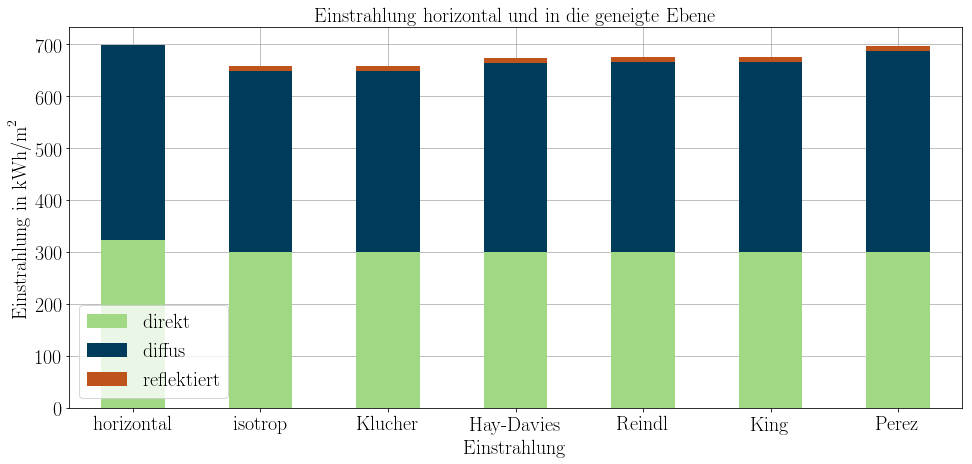

In [10]:
# Import PVlib
import pvlib
# Import of location 
from pvlib.location import Location

# Definition of parameters

# Date, time and timezone for the calculation as Pandas Timestamp
# Datetime in format "YYYY-mm-dd HH-MM-SS"
# Definition of timezone: https://en.wikipedia.org/wiki/List_of_tz_database_time_zones
times = pd.Timestamp(timestamp[0], tz='Europe/Berlin') 

# Location of the PV system
# with latitude, longitude and timezone
# Defintion of location by PVLIB class "Location"
location = Location(latitude = latitude, longitude = longitude, tz='Europe/Berlin') # Location of Umwelt-Campus Birkenfeld

# Orientation and inclination of PV modules
surface_tilt = inclination
surface_azimuth = azimuth

# Albedo
albedo=A

# Horizontal irradiance taken from CAMS CSV file
# dni: horizontal direct irradiance
# dhi: horizontal diffuse irradiance
# ghi: global horizontal irradiance
dni = df_cams.loc[timestamp[0]].bhi
dhi = df_cams.loc[timestamp[0]].dhi
ghi = df_cams.loc[timestamp[0]].ghi

# Calculation of solar position based on timestamp and location 
solarposition = pvlib.solarposition.get_solarposition(times, location.latitude, location.longitude, altitude=None, pressure=None, method='nrel_numpy', temperature=12)

# Irradiance on titled plane based on isotropic diffuse sky model
model = 'isotropic'
total_irradiance = pvlib.irradiance.total_irrad(surface_tilt, surface_azimuth, solarposition.apparent_zenith[0], solarposition.azimuth[0], dni, ghi, dhi, dni_extra=None, airmass=None, albedo=albedo, surface_type=None, model=model, model_perez='allsitescomposite1990')
df_total_irradiance = pd.DataFrame(total_irradiance, index=[model], columns=total_irradiance.keys())

# Irradiance on titled plane based on Klucher model
model = 'klucher'
total_irradiance = pvlib.irradiance.total_irrad(surface_tilt, surface_azimuth, solarposition.apparent_zenith[0], solarposition.azimuth[0], dni, ghi, dhi, dni_extra=None, airmass=None, albedo=albedo, surface_type=None, model=model, model_perez='allsitescomposite1990')
df_total_irradiance = df_total_irradiance.append(pd.DataFrame(total_irradiance, index=[model], columns=total_irradiance.keys()))

# The airmass and the extraterrestrial direct normal irradiance are mandatory input parameter
airmass = location.get_airmass(times=times, solar_position=solarposition, model='kastenyoung1989')
dni_extra = pvlib.irradiance.extraradiation(times)

# Irradiance on titled plane based on Hay-Davies model
model = 'haydavies'
total_irradiance = pvlib.irradiance.total_irrad(surface_tilt, surface_azimuth, solarposition.apparent_zenith[0], solarposition.azimuth[0], dni, ghi, dhi, dni_extra=dni_extra, airmass=airmass.airmass_absolute[0], albedo=albedo, surface_type=None, model=model, model_perez='allsitescomposite1990')
df_total_irradiance = df_total_irradiance.append(pd.DataFrame(total_irradiance, index=[model], columns=total_irradiance.keys()))

# Irradiance on titled plane based on Reindl model
model = 'reindl'
total_irradiance = pvlib.irradiance.total_irrad(surface_tilt, surface_azimuth, solarposition.apparent_zenith[0], solarposition.azimuth[0], dni, ghi, dhi, dni_extra=dni_extra, airmass=airmass.airmass_absolute[0], albedo=albedo, surface_type=None, model=model, model_perez='allsitescomposite1990')
df_total_irradiance = df_total_irradiance.append(pd.DataFrame(total_irradiance, index=[model], columns=total_irradiance.keys()))

# Irradiance on titled plane based on King model
model = 'king'
total_irradiance = pvlib.irradiance.total_irrad(surface_tilt, surface_azimuth, solarposition.apparent_zenith[0], solarposition.azimuth[0], dni, ghi, dhi, dni_extra=dni_extra, airmass=airmass.airmass_absolute[0], albedo=albedo, surface_type=None, model=model, model_perez='allsitescomposite1990')
df_total_irradiance = df_total_irradiance.append(pd.DataFrame(total_irradiance, index=[model], columns=total_irradiance.keys()))

# Irradiance on titled plane based on Perez model
model = 'perez'
total_irradiance = pvlib.irradiance.total_irrad(surface_tilt, surface_azimuth, solarposition.apparent_zenith[0], solarposition.azimuth[0], dni, ghi, dhi, dni_extra=dni_extra, airmass=airmass.airmass_absolute[0], albedo=albedo, surface_type=None, model=model, model_perez='allsitescomposite1990')
df_total_irradiance = df_total_irradiance.append(pd.DataFrame(total_irradiance, index=[model], columns=total_irradiance.keys()))

print ("\nIrradiance on titled plane based on all models")
print (df_total_irradiance)

index_xAchse = ('horizontal', 'isotrop', 'Klucher', 'Hay-Davies', 'Reindl', 'King', 'Perez')
index = pd.Index(index_xAchse, name='Einstrahlung')

data = {
    'direkt': (dni, df_total_irradiance['poa_direct']['isotropic'], df_total_irradiance['poa_direct']['klucher'], df_total_irradiance['poa_direct']['haydavies'], df_total_irradiance['poa_direct']['reindl'], df_total_irradiance['poa_direct']['king'], df_total_irradiance['poa_direct']['perez']),
    'diffus': (dhi, df_total_irradiance['poa_sky_diffuse']['isotropic'], df_total_irradiance['poa_sky_diffuse']['klucher'], df_total_irradiance['poa_sky_diffuse']['haydavies'], df_total_irradiance['poa_sky_diffuse']['reindl'], df_total_irradiance['poa_sky_diffuse']['king'], df_total_irradiance['poa_sky_diffuse']['perez']),
    'reflektiert': (0, df_total_irradiance['poa_ground_diffuse']['isotropic'], df_total_irradiance['poa_ground_diffuse']['klucher'], df_total_irradiance['poa_ground_diffuse']['haydavies'], df_total_irradiance['poa_ground_diffuse']['reindl'], df_total_irradiance['poa_ground_diffuse']['king'], df_total_irradiance['poa_ground_diffuse']['perez'])
}

df_Einstrahlung = pd.DataFrame(data, index=index)
print("\n",df_Einstrahlung)

df_tilted = pd.DataFrame(data, index=index)
ax = df_tilted.plot(kind='bar', stacked=True, figsize=(16, 7), color=(c_apfelgruen, c_technikblau, c_orange), zorder=2)
ax.set_title("Einstrahlung horizontal und in die geneigte Ebene")
ax.set_ylabel(r"Einstrahlung in $\textnormal{kWh/m}^2$")
plt.xticks(rotation=0)
ax.legend(loc="lower left", bbox_to_anchor=(0.,0.))
ax.grid(zorder=1)
plt.show()

<a id="zusammenfassung"></a>
## 5 Zusammenfassung

Die Bestimmung der Sonneneinstrahlung in die Horizontale und die Umrechnung in die geneigte Ebene für die Ertrags- sowie Performance-Ratio-Berechnung lässt sich auf unterschiedlichen Wegen realisieren. Die Registrierung bei und Nutzung des CAMS-Radiation-Services ermöglicht den standortgenauen, zeitlich aufgelösten Export der Strahlungsdaten in die horizontale Ebene. Diese Daten können entweder in der hier definierten Funktion <code>calc_tilted_irradiance</code> verarbeitet werden, um in einem Skript ohne die Installation weiterer Bibliotheken die Einstrahlung in die geneigte Modulebene zu bestimmen. Etwas aufwändiger und komplexer ist die Nutzung der PVLIB-Bibliothek, die sich auch zur Simulation von Photovoltaikanlagen eignet. 